# Online Recovery of Temporally Correlated Sparse Signals Using Multiple Measurement Vectors

In [207]:
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]
sns.set_style("darkgrid")

## Numerical Setup

In [32]:
N=50
M = 20 # Number of measurements 
S = 5 # Number of non-zero coefficents 
K = 40
sparse_support= sp.random.choice(N, S, replace=False) # s locations chosen uniformly at random
Delta=10 # Time lag allowed in estimation 
Phi = sp.random.normal(0, 1, (K, M, N)) # K measurement matrices

In [33]:
def get_x_k(k, D_coeffs, z_coeffs, x_0_coeffs):
    if k == 0:
        return x_0_coeffs
    else: 
        return  D_coeffs*get_x_k(k-1, D_coeffs, z_coeffs, x_0_coeffs) + z_coeffs[k]

# Generated via the AR process
def get_x(K, sparse_support):
    S=len(sparse_support)
    x_0_coeffs = sp.random.normal(0, 1, S) 
    D_coeffs = sp.random.uniform(0.8, 1.0, S) # Correlation matrix with diagnonal entries chosen uniformly from [0.8, 1]
    z_coeffs = sp.random.normal(0, (1-D_coeffs**2)[1], (K, S))
    x=[sp.sparse.csr_matrix((get_x_k(k, D_coeffs, z_coeffs, x_0_coeffs), (
        sparse_support, sp.zeros(S))), shape=(N,1)) for k in range(K)]
    return sp.sparse.hstack(x), D_coeffs, z_coeffs

In [74]:
x, D_coeffs, z_coeffs = get_x(40, sparse_support)

#### Example X

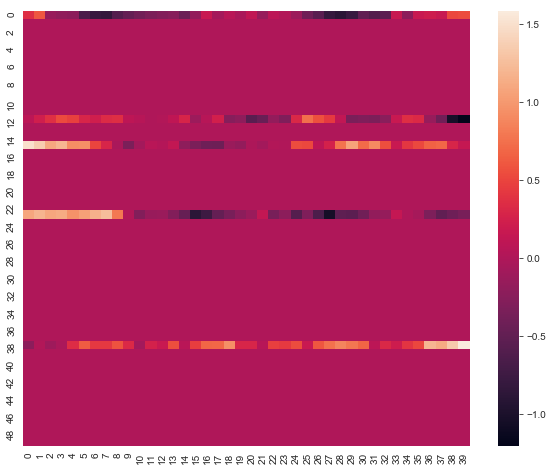

In [75]:
sns.heatmap(x.todense())

In [226]:
def get_y_k(x_k, Phi_k, noise=0):
    return Phi_k*x_k + noise

In [306]:
def get_y(x, Phi, noise=0):    
    return sp.hstack([Phi[k]*x.tocsc()[:,k] + noise for k in range(x.shape[1])])

#### Example Y

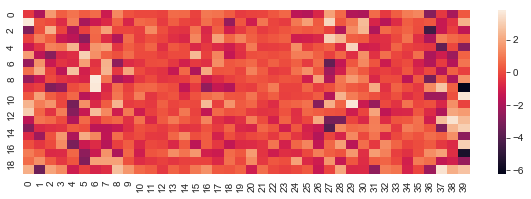

In [310]:
plt.figure(figsize=(10, 3))
sns.heatmap(get_y(x, Phi))

In [272]:
y_0 = get_y_k(x.tocsc()[:,0], Phi[0])

#### Example $y_k$

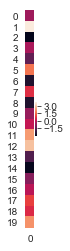

In [273]:
plt.figure(figsize=(0.2, 4))
sns.heatmap(y_0)

## Performance Metrics

### Mean Squared Error (MSE)

In [161]:
# Inputs are NxK matrices 
# For array inputs need **2, for sparse matrices can do .power
# Text for correct axis: 
# testx = sp.sparse.csr_matrix([[0, 0],[0, 0]])
# testxh = sp.sparse.csr_matrix([[1,0],[1, 0]])
# Answer should be [1., 0.], before summing
def get_mse(x_hat, x):
    return ((x_hat - x).power(2)).mean(axis=0).sum()

### Support Recovery Rate (SRR)

In [223]:
# x_hat is a scipy sparse NxK matrix 
# for each k, computes the number of support indices the estimate missed, 
# divided by the cardinaity of the sparse support, then averages over k
# 1-miss rate ===> success rate
def get_ssr(x_hat, sparse_support):
    x_sup = set(sparse_support)
    # make support dictionary from the nonzero elements of x_hat
    x_hat_sup = defaultdict(list)
    for i, k in zip(*x_hat.nonzero()):
        x_hat_sup[k].append(i)
    return 1-sp.mean([len(x_sup.difference(set(x_hat_sup[k])))/float(len(x_sup)) 
                      for k in range(x_hat.shape[1])])

### Run Time

In [206]:
%%timeit -n1
1+1

1 loop, best of 3: 0 ns per loop


## Offline KSLB

Here we are assuming we have all measurement matrices and vectors at hand.

We employ the python library Pykalman: https://pykalman.github.io/

In [314]:
import pykalman as pk
import numpy as np

In [357]:
y = get_y(x, Phi).T # measurements
diags = sp.zeros(N) 
diags[sparse_support] = D_coeffs
D = sp.diag(diags) # Construct the diagonal matrix with sparse entries sampled uniformly earlier

In [409]:
kf = pk.KalmanFilter(transition_matrices = D , observation_matrices = Phi, em_vars= ['initial_state_covariance', 'transitional_covariance']) #

In [415]:
kf = kf.em(y, em_vars= ['initial_state_covariance', 'transitional_covariance'], n_iter=100) #

In [416]:
kf.initial_state_mean

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [418]:
kf

array([[0.89315361, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

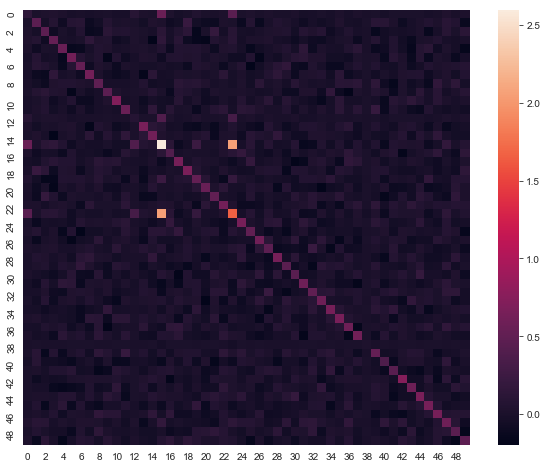

In [413]:
sns.heatmap(kf.initial_state_covariance)

In [363]:
(filtered_state_means, filtered_state_covariances) = kf.filter(y)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(y)

(50, 50)

## Online Fixed Lag KSBL